In [20]:
%matplotlib inline

import numpy as np
from astropy import units as u

import tabulation
from tqdm.notebook import tqdm

import betterplotlib as bpl
bpl.presentation_style()

In [18]:
lt = tabulation.Lifetimes("Raiteri_96")

In [16]:
import sys, os
sys.path.append(os.path.abspath("../../build/"))
from wind_enrich_ia_elts_cluster_discrete import lib as winds
winds.detailed_enrichment_init()

In [58]:
dt = 1E5

In [59]:
times = dict()
turnoff_masses = dict()
def generate_times(zs):
    for z in zs:
        times[z] = np.arange(0, 50E6, dt)
        turnoff_masses[z] = [lt.turnoff_mass(t, z) for t in tqdm(times[z])]

In [60]:
zs = [0.02, 0.01, 0.004, 0.001, 0]

In [61]:
generate_times(zs)

In [62]:
age_50s = dict()
for z in zs:
    age_50s[z] = lt.lifetime(50, z)

In [63]:
wind_duration = 5E6
sb99_wind_pdot = (2E32 / 1E6) * u.dyne / u.solMass

def current_art(t_now, t_next, Z, mass):
    if t_now > wind_duration:
        return 0
    mass *= u.solMass
    this_dt = (t_next - t_now) * u.year
    dp = sb99_wind_pdot * (Z / 0.02) * this_dt * mass
    return dp.to(u.g * u.cm / u.s).value

In [79]:
my_v = 7000 * u.km / u.s
def my_update(t_now, t_next, m_now, m_next, Z, mass):
    
    dm = winds.get_ejecta_winds_py(t_now, t_next,
                                   m_now, m_next,
                                   mass, Z, age_50s[z])
    
    dm *= u.solMass
    dp = my_v * dm
    return dp.to(u.g * u.cm / u.s).value
                                

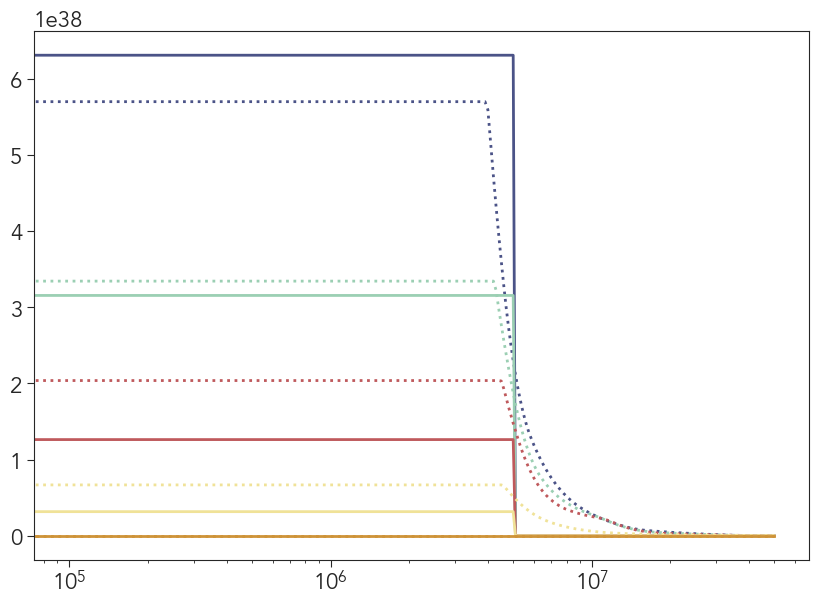

In [81]:
fig, ax = bpl.subplots()

for idx_z, z in enumerate(times):
    
    ejecta_rate_new = []
    ejecta_rate_old = []
    
    for idx in range(len(times[z])-1):
        age_now = times[z][idx]
        age_next = times[z][idx+1]
        
        m_now = turnoff_masses[z][idx]
        m_next = turnoff_masses[z][idx+1]
        
        rate_old = current_art(age_now, age_next, z, 1)
        rate_new = my_update(age_now, age_next, m_now, m_next, z, 1)
        
        ejecta_rate_old.append(rate_old)
        ejecta_rate_new.append(rate_new)
        
    ax.plot(times[z][:-1], ejecta_rate_old, lw=2, ls="-", c=bpl.color_cycle[idx_z], label="Old: {}".format(z))
    ax.plot(times[z][:-1], ejecta_rate_new, lw=2, ls=":", c=bpl.color_cycle[idx_z], label="New: {}".format(z))

ax.set_xscale("log")